In [ ]:
INPUT Shape= 224*224 
Batch_Size = 64

In [2]:
# Importing Tools & Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [3]:
# Loading Dataset Labels
train_df = pd.read_csv('/kaggle/input/urpc19/URPC19_TF/train/_annotations.csv')
test_df = pd.read_csv('/kaggle/input/urpc19/URPC19_TF/test/_annotations.csv')  
valid_df = pd.read_csv('/kaggle/input/urpc19/URPC19_TF/valid/_annotations.csv')

In [4]:
# Creating Image DataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
# Training data generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/input/urpc19/URPC19_TF/train',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 28427 validated image filenames belonging to 4 classes.


In [6]:
# Validation data generator

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='/kaggle/input/urpc19/URPC19_TF/valid',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 5676 validated image filenames belonging to 4 classes.


In [7]:
# Test data generator

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/kaggle/input/urpc19/URPC19_TF/test',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 1994 validated image filenames belonging to 4 classes.


In [8]:
# Confirmation of split Samples

print(f"Training samples: {len(train_generator.filenames)}")
print(f"Validation samples: {len(valid_generator.filenames)}")
print(f"Test samples: {len(test_generator.filenames)}")

Training samples: 28427
Validation samples: 5676
Test samples: 1994


In [9]:
# Define Fine Tuned CNN Architecture 

model = Sequential([

    Conv2D(140, (3, 3), activation='relu', strides=1, padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(124, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    

    Conv2D(44, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(380, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(460, activation='relu'),
    (Dropout(0.2)),

    Dense(56, activation='relu'),

    Dense(188, activation='relu'),

# Output layer with softmax activation for classification

    Dense(4, activation='softmax') 
])


learning_rate = 0.0003102     #  We Can Adjust this value for Adam Learning rate
optimizer = Adam(learning_rate=learning_rate)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the Model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Printing Model Details

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 140)  │         3,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 140)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 124)  │       156,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 124)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 53, 44)     │        49,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 44)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 380)    │       150,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 380)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 54720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │    25,171,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           756 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,569,240 (97.54 MB)

 Trainable params: 25,569,240 (97.54 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Model Training

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    epochs=20
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718781278.086416     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718781278.106072     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


432/444 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - accuracy: 0.5583 - loss: 2.0188

W0000 00:00:1718781432.002930     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.5597 - loss: 1.9965

W0000 00:00:1718781437.533299     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


444/444 ━━━━━━━━━━━━━━━━━━━━ 241s 430ms/step - accuracy: 0.5598 - loss: 1.9947 - val_accuracy: 0.6351 - val_loss: 0.9448
Epoch 2/20
  1/444 ━━━━━━━━━━━━━━━━━━━━ 2:20 318ms/step - accuracy: 0.6094 - loss: 1.0297

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


444/444 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.6094 - loss: 1.0297 - val_accuracy: 0.6364 - val_loss: 0.8909
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 164s 359ms/step - accuracy: 0.6248 - loss: 0.9628 - val_accuracy: 0.6380 - val_loss: 0.9491
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.7188 - loss: 0.8445 - val_accuracy: 0.6591 - val_loss: 0.9299
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 159s 352ms/step - accuracy: 0.6311 - loss: 0.9421 - val_accuracy: 0.6404 - val_loss: 0.9466
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 134us/step - accuracy: 0.6875 - loss: 0.8251 - val_accuracy: 0.5682 - val_loss: 0.9618
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 156s 345ms/step - accuracy: 0.6377 - loss: 0.9051 - val_accuracy: 0.6360 - val_loss: 0.9649
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.6719 - loss: 0.7700 - val_accuracy: 0.6818 - val_loss: 0.9935
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 153s 340ms/step - accuracy: 0.6378 - loss: 0.8847 - val

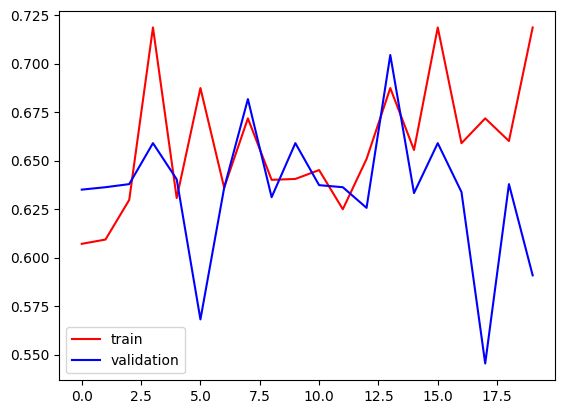

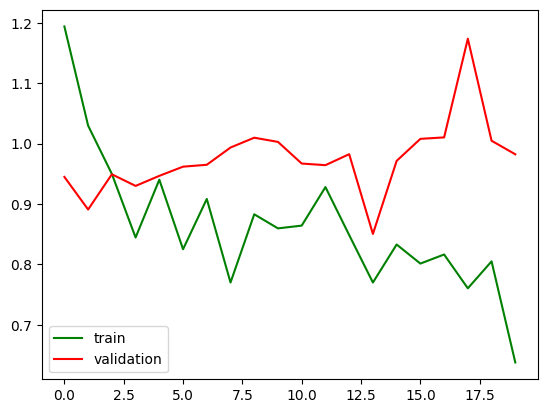

In [13]:
# Ploting Val_Accuracy & Val_Loss Graph

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


plt.plot(history.history['loss'],color='Green',label='train')
plt.plot(history.history['val_loss'],color='red',label='validation')
plt.legend()
plt.show()

In [14]:
# Model Evaluation 

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.6581 - loss: 0.9090
Test loss: 0.9099929928779602
Test accuracy: 0.6638104915618896


In [15]:
# Printing Classification Report
test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step  

W0000 00:00:1718782967.809873     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step
              precision    recall  f1-score   support

     echinus       0.42      0.71      0.53       835
 holothurian       0.10      0.00      0.01       275
     scallop       0.31      0.24      0.27       635
    starfish       0.14      0.05      0.08       249

    accuracy                           0.38      1994
   macro avg       0.24      0.25      0.22      1994
weighted avg       0.31      0.38      0.32      1994



W0000 00:00:1718782979.343915     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


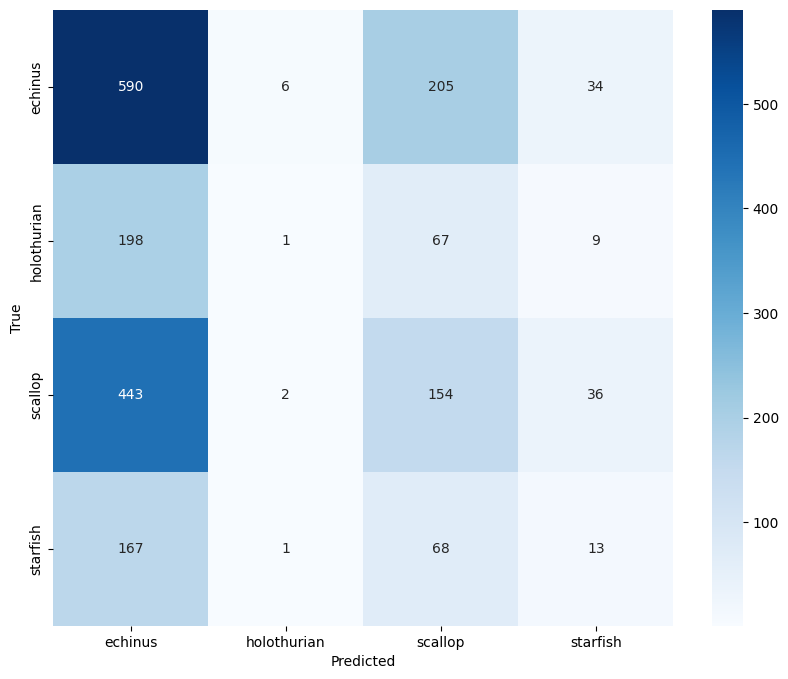

In [16]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
# Printing precision, Recall, F1 score

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.3074405860563252
Recall: 0.3801404212637914
F1 Score: 0.3186524941084582


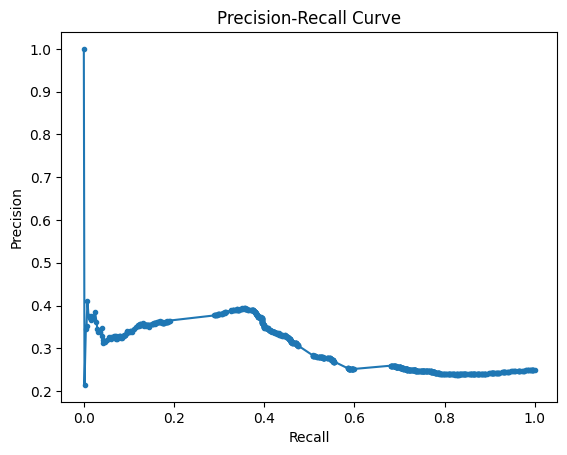

In [18]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for precision-recall curve
y_test_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))
y_score_bin = preds

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin.ravel(), y_score_bin.ravel())

plt.figure()
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
# Save the VGG16 model
model.save('CACNN_URPC2019( %).h5')